https://austinrochford.com/posts/intro-prob-prog-pymc.html#Probabilistic-programming-from-three-perspectives

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from warnings import filterwarnings
from aesara import pprint
from matplotlib import pyplot as plt, ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
filterwarnings('ignore', category=RuntimeWarning, message="overflow encountered in exp")
filterwarnings('ignore', category=UserWarning, module='pymc',
               message="Unable to validate shapes: Cannot sample from flat variable")

FIG_SIZE = np.array([8, 6])
plt.rc('figure', figsize=FIG_SIZE)

dollar_formatter = ticker.StrMethodFormatter("${x:,.2f}")
pct_formatter = ticker.StrMethodFormatter("{x:.1%}")

sns.set(color_codes=True)

## 1. Circle

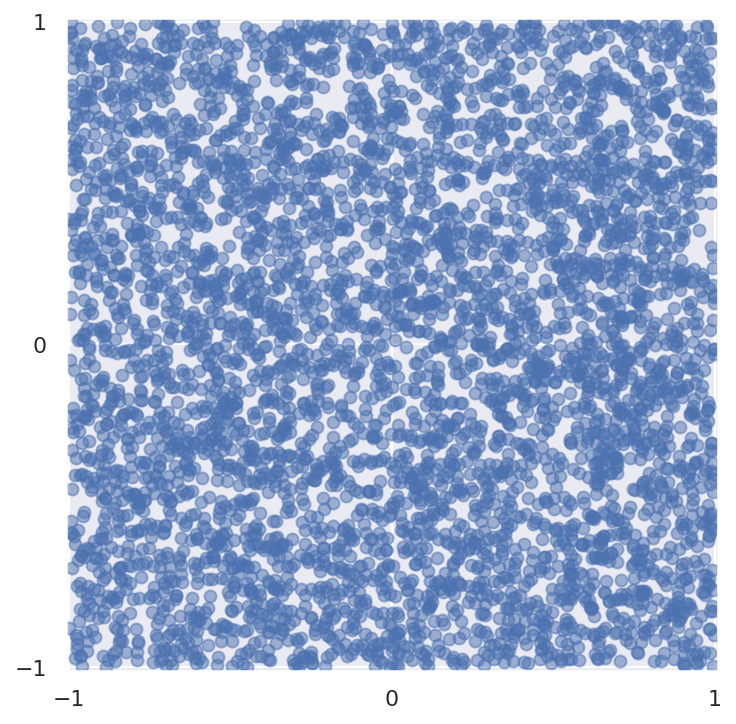

In [3]:
SEED = 123456789 # for reproducibility

rng = np.random.default_rng(SEED)

N = 5_000

x, y = rng.uniform(-1, 1, size=(2, N))
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ax.scatter(x, y, alpha=0.5);

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

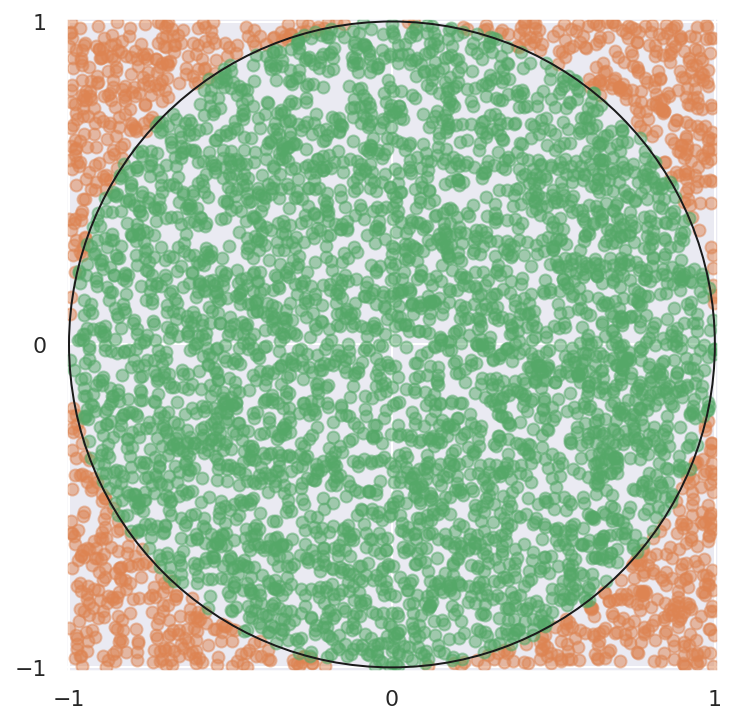

In [4]:
in_circle = x**2 + y**2 < 1
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ax.scatter(x[~in_circle], y[~in_circle], c='C1', alpha=0.5);
ax.scatter(x[in_circle], y[in_circle], c='C2', alpha=0.5);

ax.add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor='k'));

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

In [5]:
in_circle.shape

(5000,)

In [6]:
x.shape

(5000,)

In [7]:
y.shape

(5000,)

In [8]:
4 * in_circle.mean()

3.1488

## 2. The Monty Hall Problem

In [9]:
import pymc as pm
with pm.Model() as monty_model:
    car = pm.DiscreteUniform("car", 0, 2)

In [10]:
from aesara import tensor as at

p_open = at.switch(
    at.eq(car, 0),
    np.array([0, 0.5, 0.5]), # it is behind the first door
    at.switch(
        at.eq(car, 1),
        np.array([0, 0, 1]), # it is behind the second door
        np.array([0, 1, 0])  # it is behind the third door
    )
)

In [11]:
with monty_model:
    opened = pm.Categorical("opened", p_open, observed=2)

In [12]:
opened.shape

TensorConstant{[]}

In [13]:
with monty_model:
    monty_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [car]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
monty_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
monty_trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    car      (chain, draw) int64 0 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 1 1 0 1 1 1 1 1
Attributes:
    created_at:                 2022-10-20T06:05:12.687394
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              1.4500515460968018
    tuning_steps:               1000

In [16]:
(monty_trace.posterior["car"] == 0).mean()

<xarray.DataArray 'car' ()>
array(0.331)

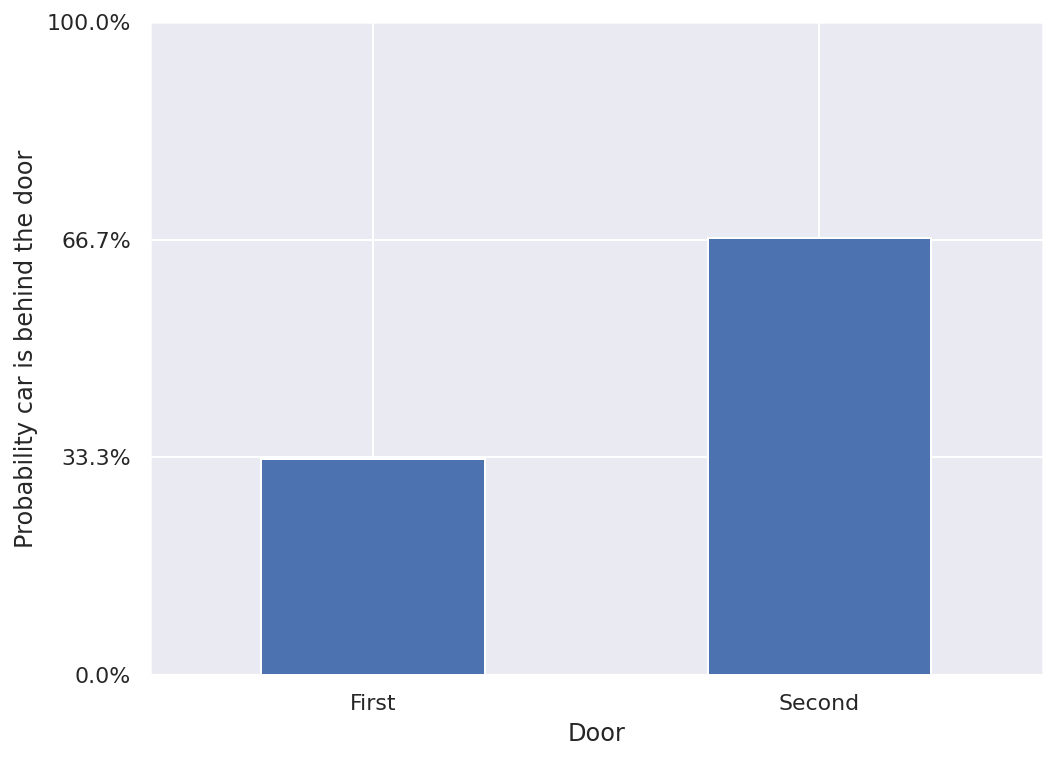

In [17]:
ax = (monty_trace.posterior["car"]
                 .to_dataframe()
                 .value_counts(normalize=True, sort=False)
                 .plot.bar(rot=0))

ax.set_xticklabels(["First", "Second"]);
ax.set_xlabel("Door");

ax.set_yticks(np.linspace(0, 1, 4));
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability car is behind the door");

## 3. OLS


### 3.1. The problem

In [18]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5], dtype=np.float64)
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

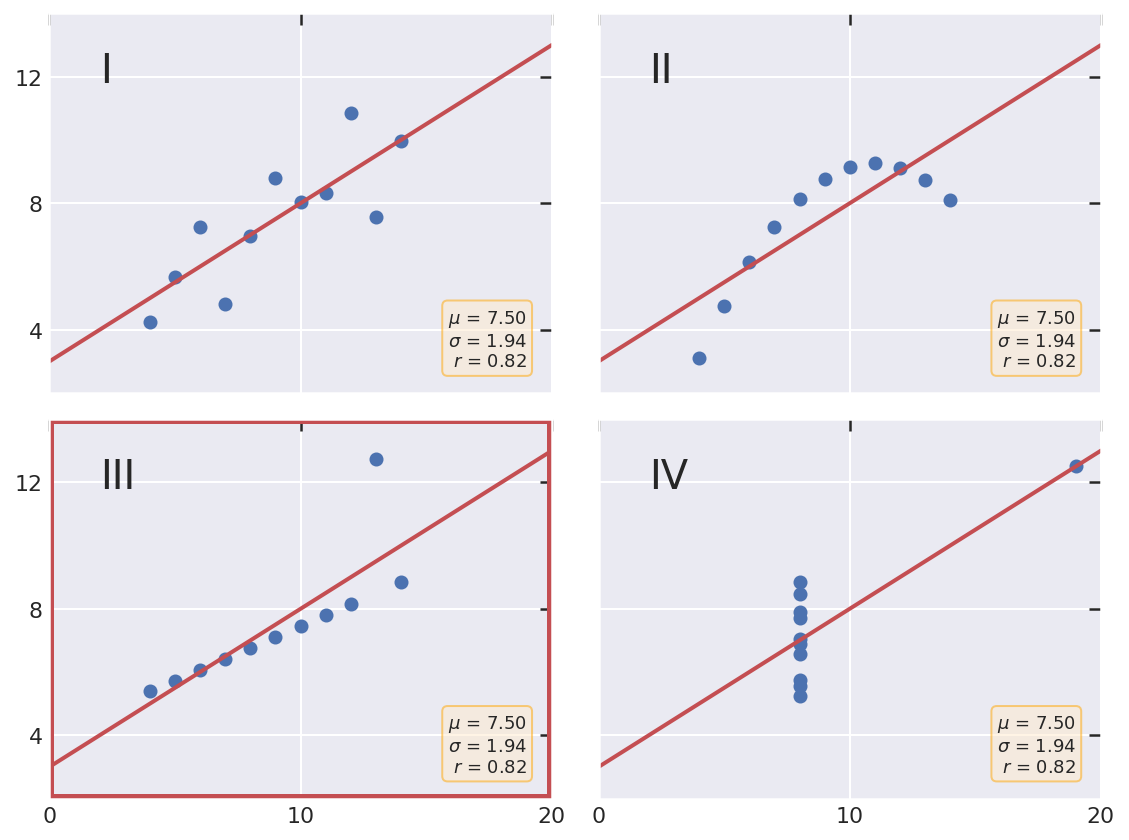

In [19]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

for ax, (label, (x_, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x_, y, 'o')

    # linear regression
    p1, p0 = np.polyfit(x_, y, deg=1)  # slope, intercept
    ax.axline(xy1=(0, p0), slope=p1, color='r', lw=2)

    # add text box for the statistics
    stats = (f'$\\mu$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$r$ = {np.corrcoef(x_, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')
    
axs[1, 0].add_artist(plt.Rectangle((0, 2), 20, 12, fill=False, edgecolor='r', lw=5));

fig.tight_layout();

Note: We use problem \#3 from the above i.e. `(x, y3)`.

### 3.2. Numpy Ordinary Least Squares (OLS) Regression

First, we see the results of Numpy's OLS and see how it compares with the expected (Robust) regression.

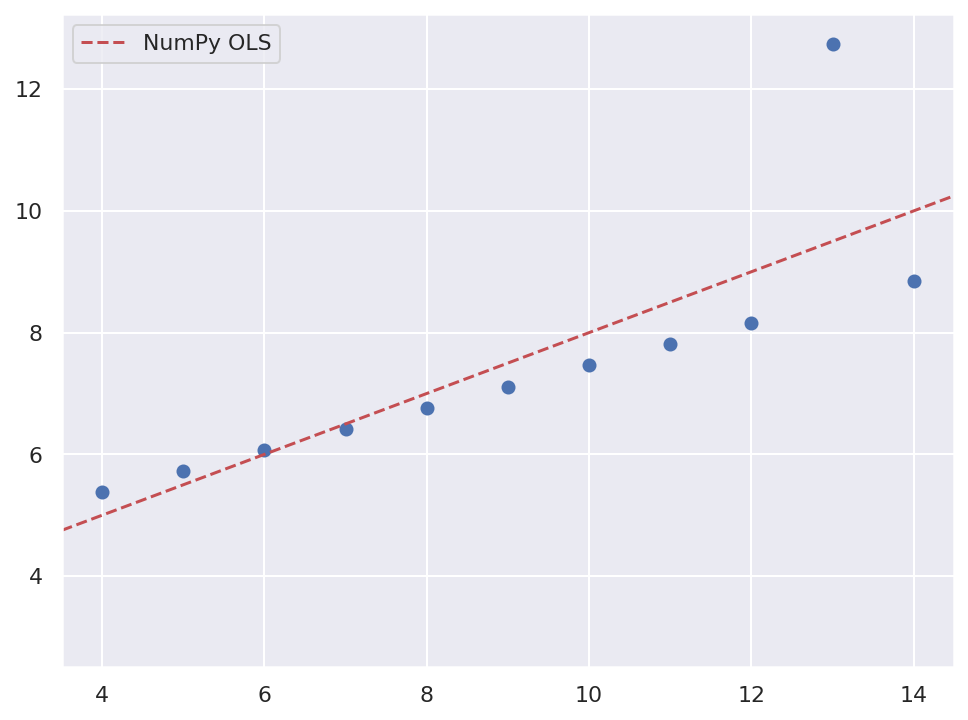

In [20]:
m_ols, b_ols = np.polyfit(x, y3, deg=1)
def plot_line(m, b, *, ax, **kwargs):
    ax.axline((0, b), slope=m, **kwargs)
    
    return ax
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

In [21]:
is_outlier = x == 13

m_robust, b_robust = np.polyfit(x[~is_outlier], y3[~is_outlier], deg=1)

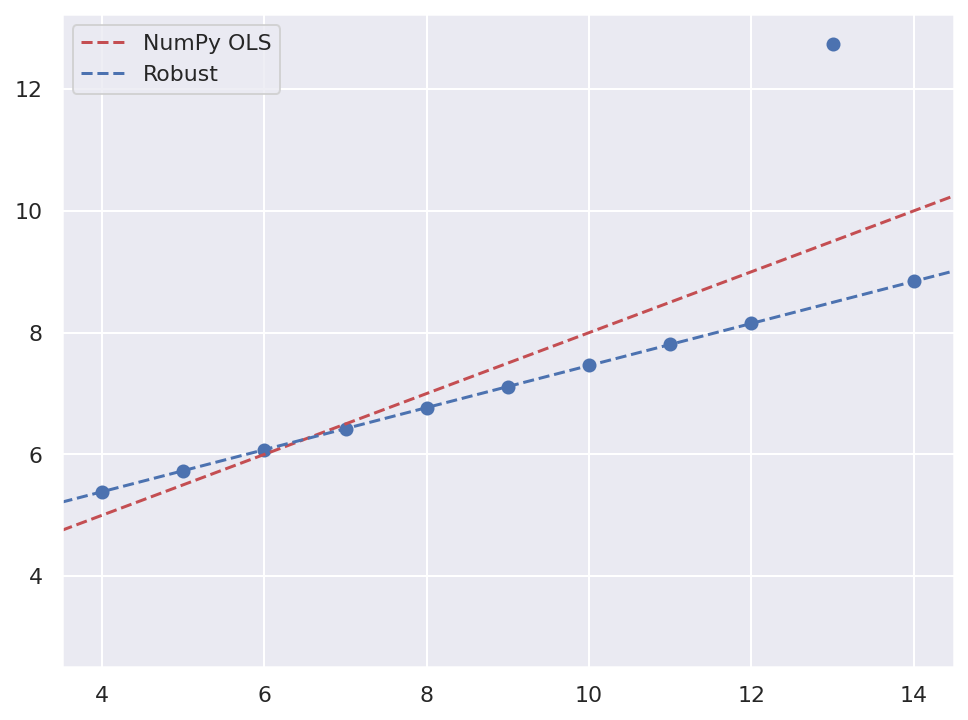

In [22]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);

plot_line(m_robust, b_robust, ls='--', label="Robust", ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

### 3.3. PyMC OLS

In [23]:
with pm.Model() as ols_model:
    m = pm.Flat("m")
    b = pm.Flat("b")
    
    σ = pm.HalfFlat("σ")

In [24]:
with ols_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)

In [25]:
CORES = 3

SAMPLE_KWARGS = {
    'cores': CORES,
    'random_seed': (SEED + np.arange(CORES)).tolist()
}

In [26]:
with ols_model:
    ols_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987, but should be close to 0.8. Try to increase the number of tuning steps.


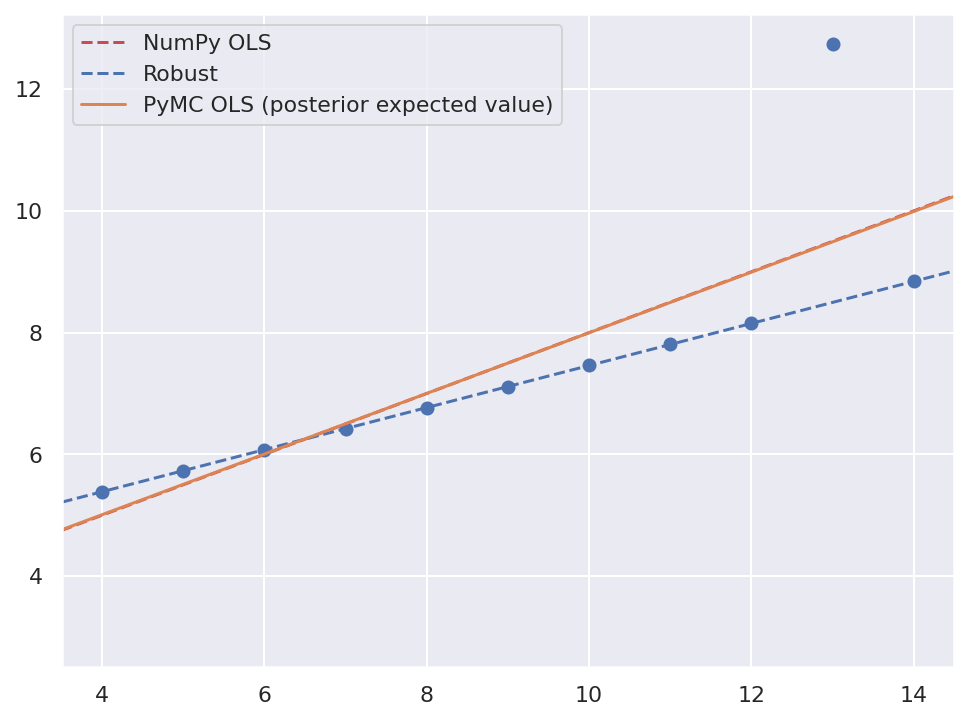

In [27]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);

plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

ax.set_xlim(3.5, 14.5);

ax.legend();

In [28]:
THIN = 50

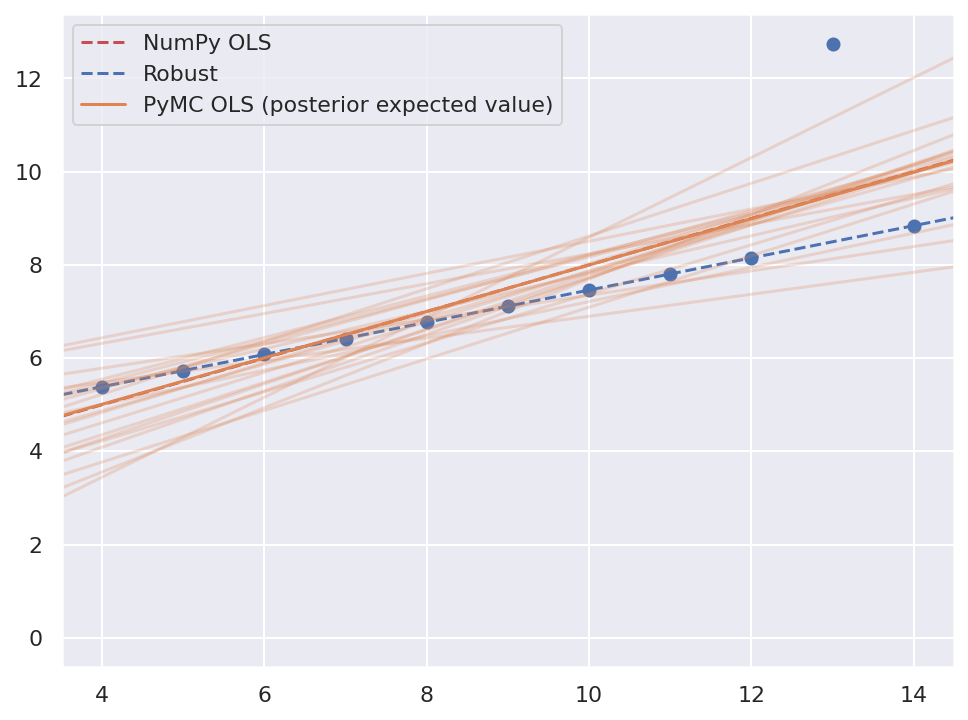

In [29]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);

plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

for m, b in (ols_trace.posterior[["m", "b"]]
                      .sel(chain=0)
                      .thin(THIN)
                      .to_array().T):
    plot_line(m.values, b.values, c='C1', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

Nope. Still doesn't work.

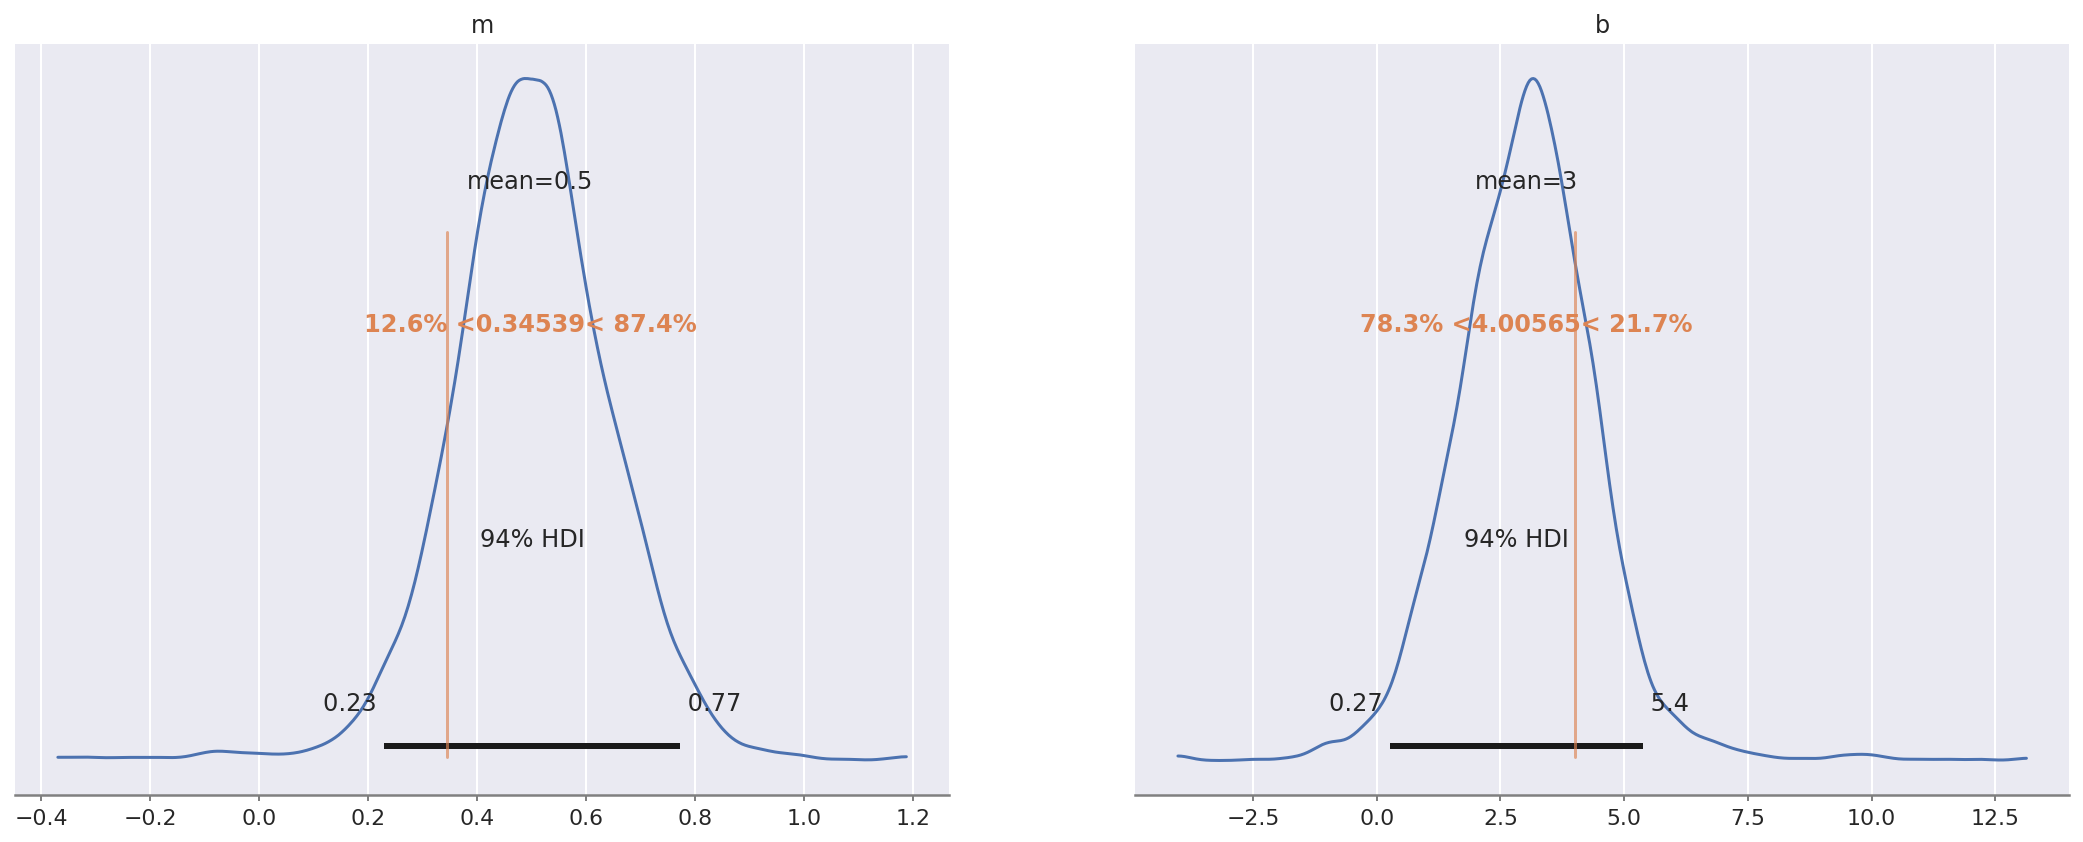

In [30]:
import arviz as az
az.plot_posterior(ols_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

### 3.4. PyMC Bayesian Ridge Regression

Now that we have become acquainted with ArviZ and xarray, we return to the third data set in Anscombe's quartet and robust regression. One way to introduce robustness in a statistical model is to add regularization). In our OLS model, the priors on m, b, and σ assign the same likelihood to all valid values of these parameters, so extremely large values are just as likely as small values. We can change the prior distributions on these parameters to ones that assign higher probability to smaller (absolute) values as a form of regularization. In fact, normal priors on m and b are equivalent to ridge regression. **The regularization parameter in ridge regression is related to the scale of the normal prior distributions on m and b.**

[Source](https://austinrochford.com/posts/intro-prob-prog-pymc.html#Bayesian-Ridge-Regression)

In [31]:
with pm.Model() as ridge_model:
    m = pm.Normal("m", 0, 2.5)
    b = pm.Normal("b", 0., 10)
    σ = pm.HalfNormal("σ", 2.5)

with ridge_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)
    
with ridge_model:
    ridge_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


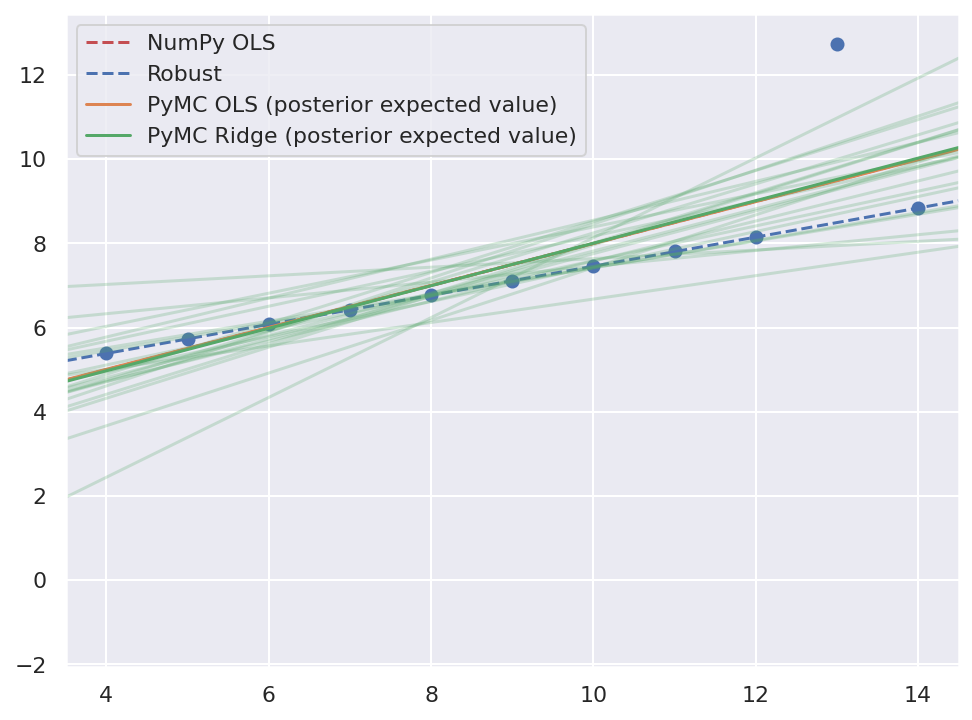

In [32]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);
plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

plot_line(
    ridge_trace.posterior["m"].mean(dim=("chain", "draw")),
    ridge_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C2', label="PyMC Ridge (posterior expected value)", ax=ax
);

for m, b in (ridge_trace.posterior[["m", "b"]]
                        .sel(chain=0)
                        .thin(THIN)
                        .to_array().T):
    plot_line(m.values, b.values, c='C2', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

Nope. Doesn't work either.

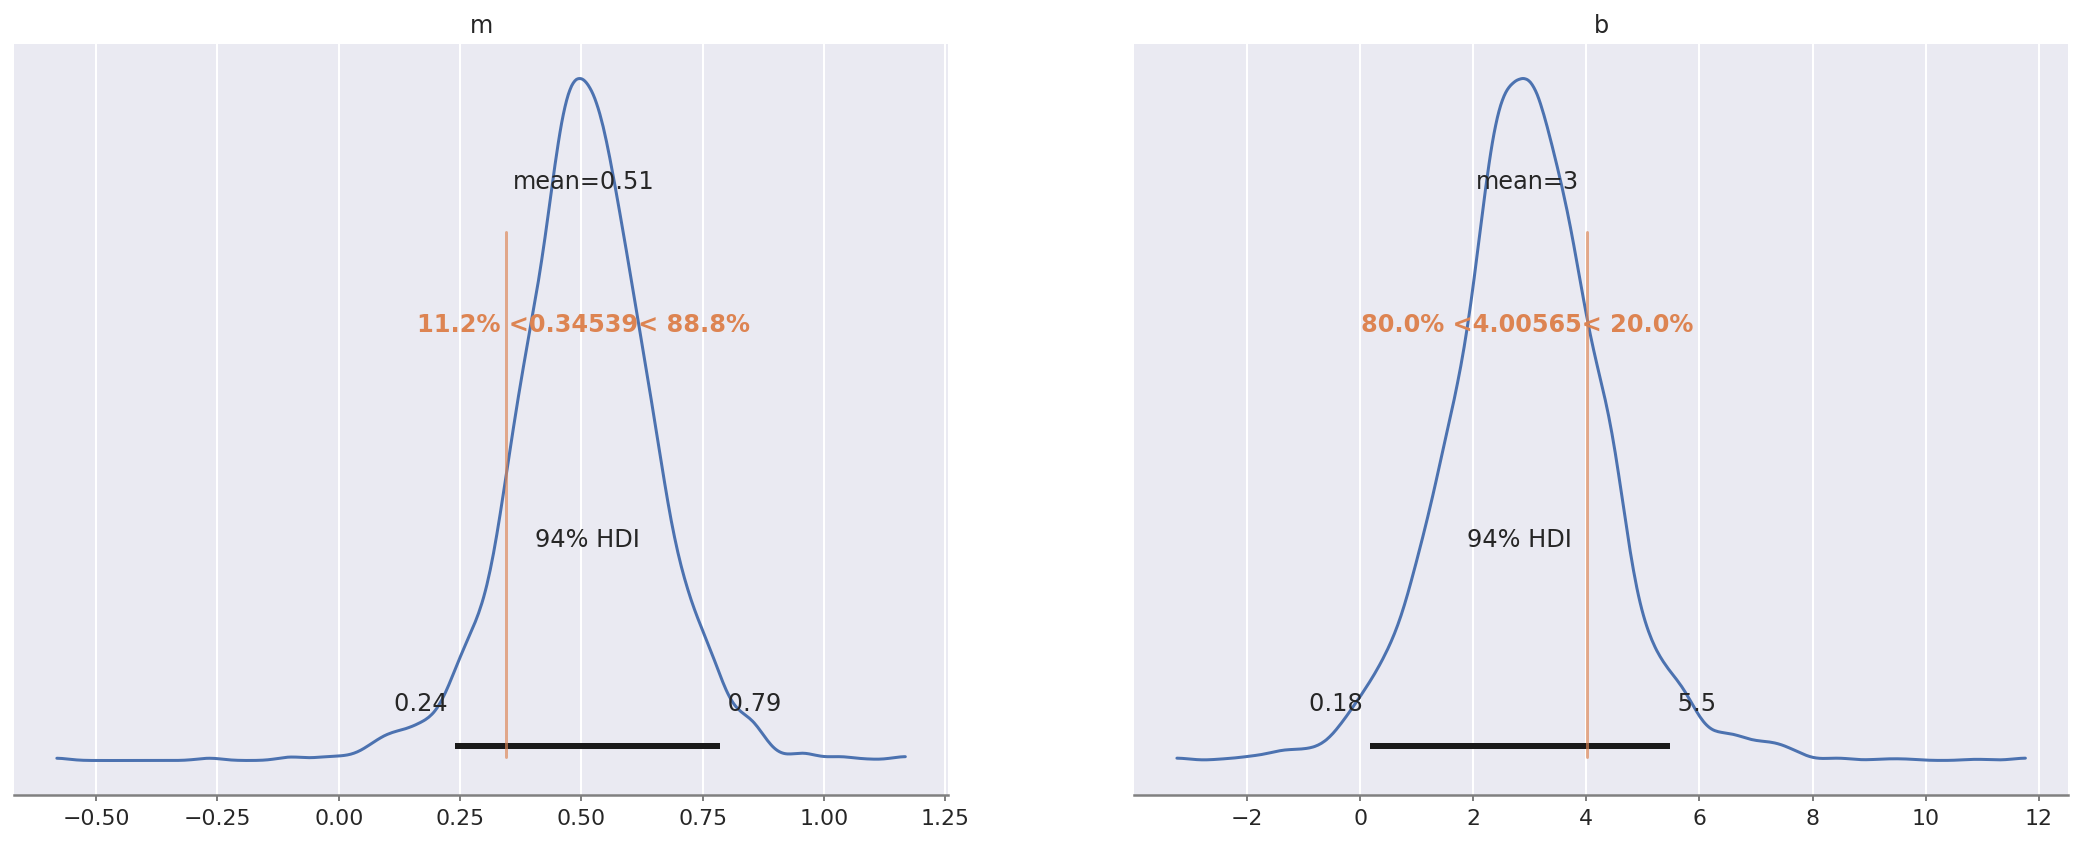

In [33]:
az.plot_posterior(ridge_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

### 3.5. PyMC Robust Regression

To add robustness against outlier y-values, we change the distribution of the observations from a normal distribution to a fatter-tailed distribution. Student's t-distribution has a shape similar to that of the normal distribution, but with fatter tails.

Here is how a Student's t-distribution looks like compared to a standard normal distribution:

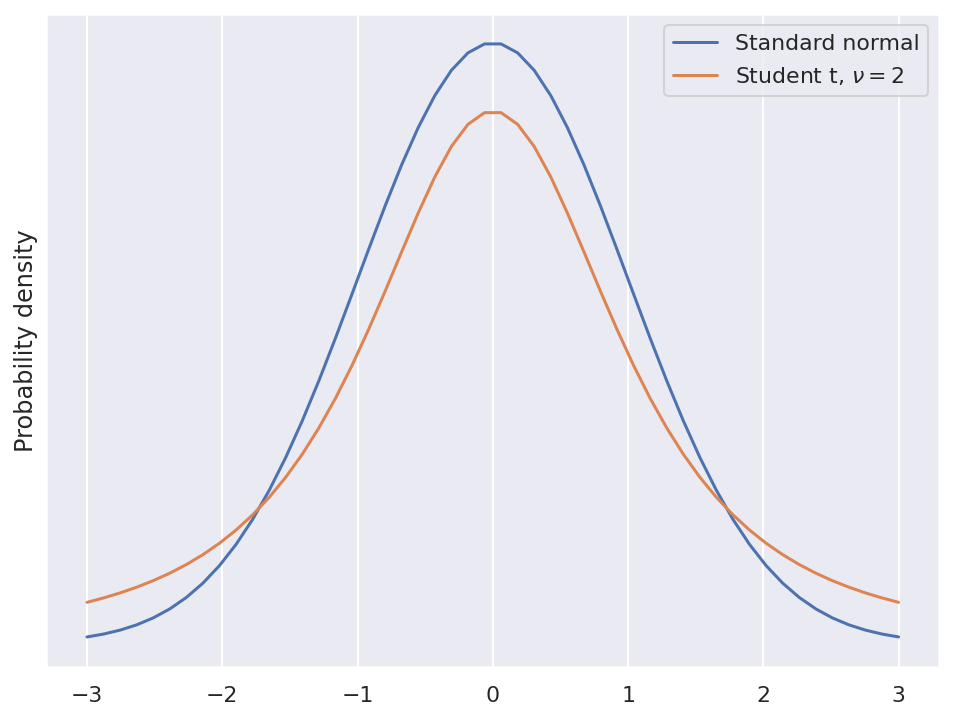

In [34]:
fig, ax = plt.subplots()

x_plot = np.linspace(-3, 3)
ax.plot(x_plot, sp.stats.norm.pdf(x_plot),
        label="Standard normal");

DF = 2
ax.plot(x_plot, sp.stats.t.pdf(x_plot, DF),
        label=f"Student t, $\\nu = {DF}$");

ax.set_yticks([]);
ax.set_ylabel("Probability density");

ax.legend();

And now, the model.

In [36]:
with pm.Model() as robust_model:
    m = pm.Normal("m", 0, 2.5)
    b = pm.Normal("b", 0., 10)
    σ = pm.HalfNormal("σ", 2.5)

# This is the addition that differentiate this model from the previous ridge regression model
with robust_model:
    ν = pm.Uniform("ν", 1, 10)
    
with robust_model:
    # The student's t-distribution is used here.
    y_obs = pm.StudentT("y_obs", nu=ν, mu=m * x + b, sigma=σ, observed=y3)
    
    robust_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ, ν]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.


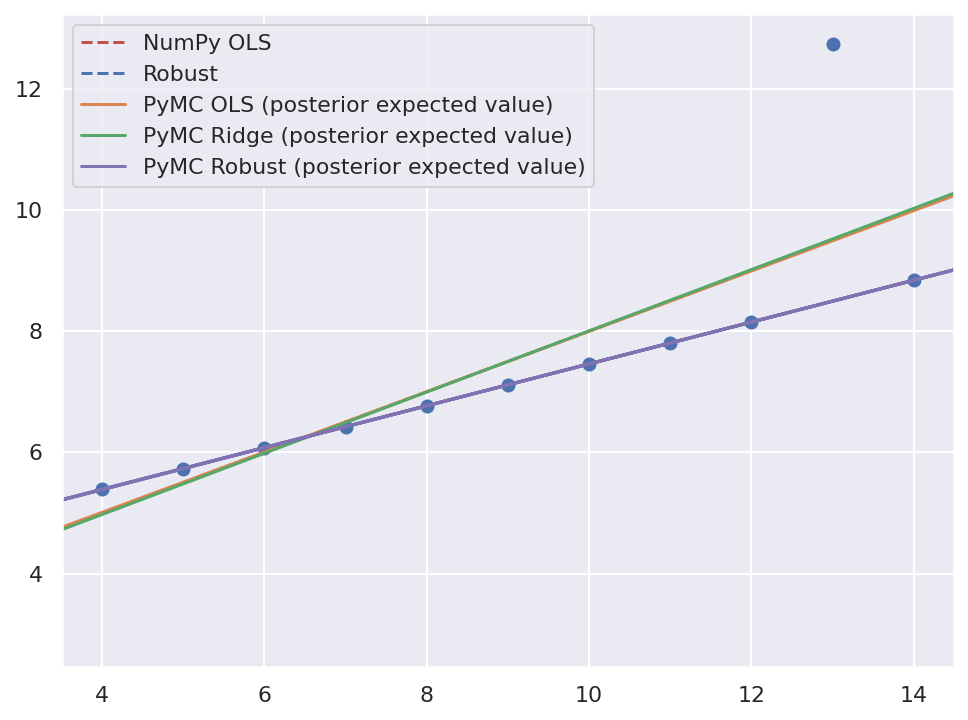

In [37]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);
plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);
plot_line(
    ridge_trace.posterior["m"].mean(dim=("chain", "draw")),
    ridge_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C2', label="PyMC Ridge (posterior expected value)", ax=ax
);

plot_line(
    robust_trace.posterior["m"].mean(dim=("chain", "draw")),
    robust_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C4', label="PyMC Robust (posterior expected value)", ax=ax
);


for m, b in (robust_trace.posterior[["m", "b"]]
                         .sel(chain=0)
                         .thin(THIN)
                         .to_array().T):
    plot_line(m.values, b.values, c='C4', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

**It works now!** Notice the PyMC Robust regression line overlays the Robust regression line exactly.

The posterior plots for this model show the true (robust) m and b comfortably in the middle of their high posterior density intervals.

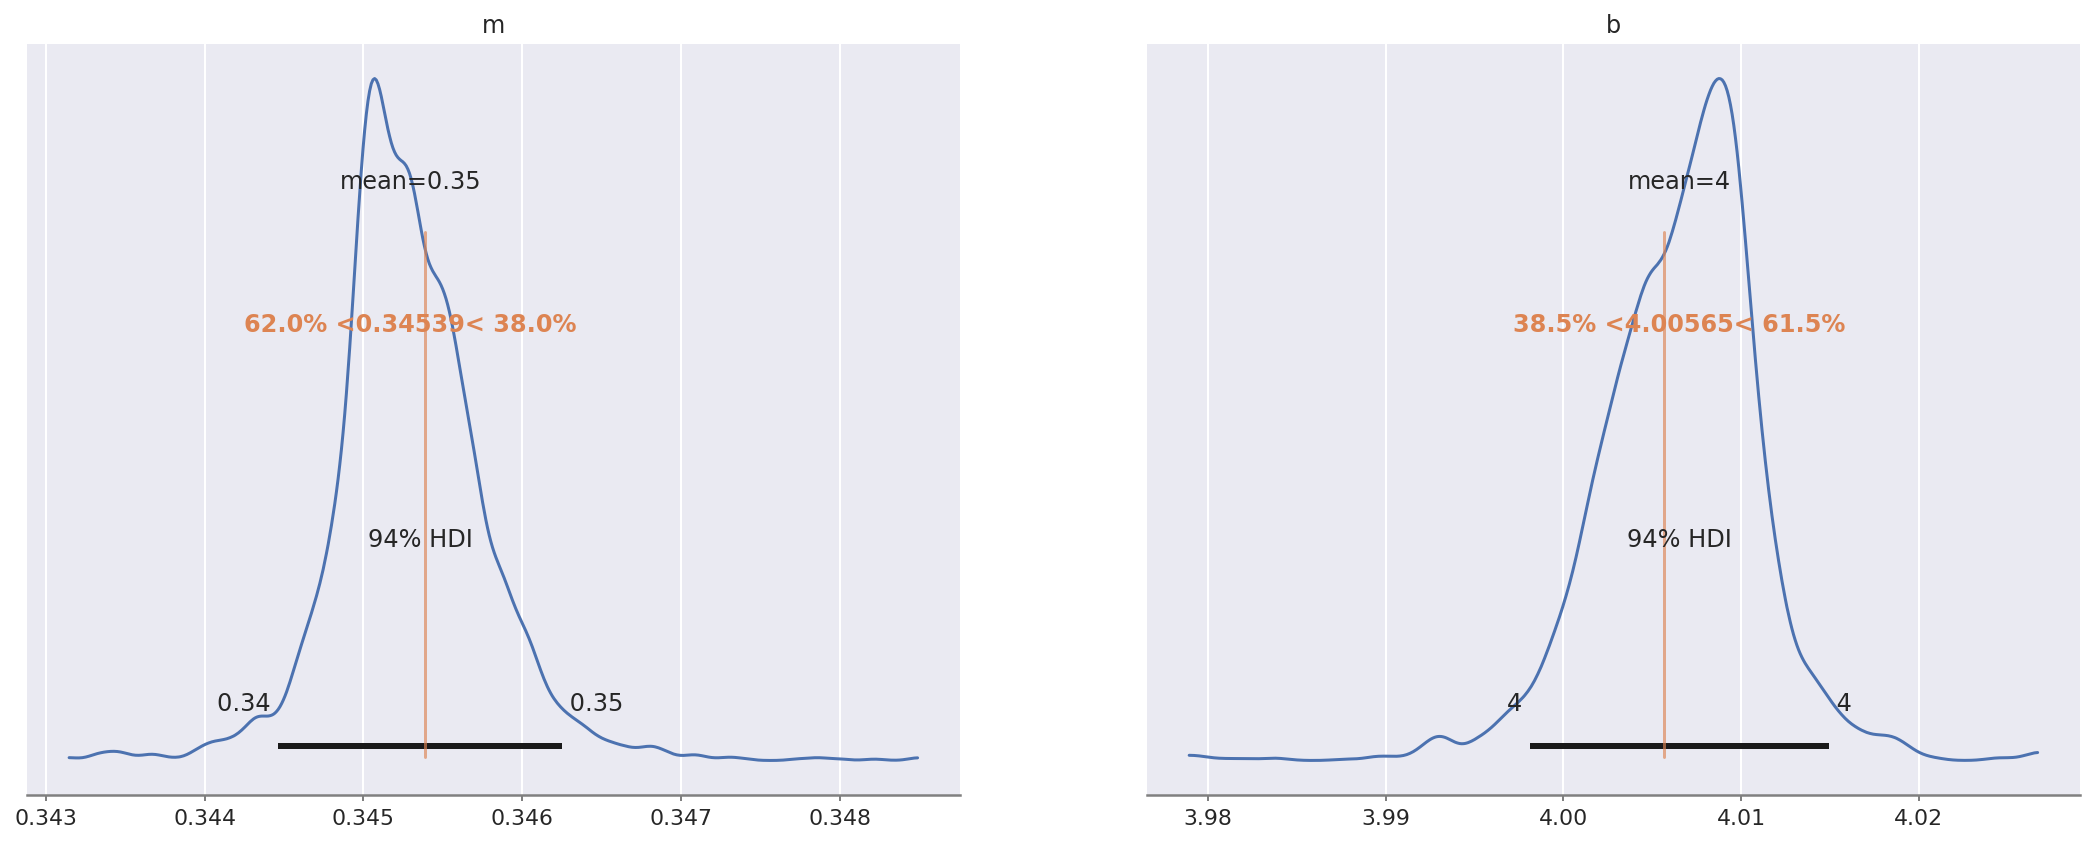

In [38]:
az.plot_posterior(robust_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

## 4. A Bayesian analysis of Lego set prices

[source](https://austinrochford.com/posts/intro-prob-prog-pymc.html#A-Bayesian-analysis-of-Lego-set-prices)

In [39]:
LEGO_DATA_URL = "https://austinrochford.com/resources/talks/data_umbrella_brickset_19800101_20211098.csv"
lego_df = pd.read_csv(LEGO_DATA_URL, parse_dates=["Year released"], index_col="Set number")
lego_df["Year released"] = lego_df["Year released"].dt.year
lego_df

Name Set type       Theme  \
Set number                                                        
1041-2      Educational Duplo Building Set   Normal       Dacta   
1075-1       LEGO People Supplementary Set   Normal       Dacta   
5233-1                             Bedroom   Normal   Homemaker   
6305-1                   Trees and Flowers   Normal        Town   
6306-1                          Road Signs   Normal        Town   
...                                    ...      ...         ...   
80025-1          Sandy's Power Loader Mech   Normal  Monkie Kid   
80026-1                Pigsy's Noodle Tank   Normal  Monkie Kid   
80028-1                     The Bone Demon   Normal  Monkie Kid   
80106-1                      Story of Nian   Normal    Seasonal   
80107-1            Spring Lantern Festival   Normal    Seasonal   

            Year released  Pieces                       Subtheme    RRP$  \
Set number                                                                 
1041-2               1980    68.0                            NaN   36.50   
1075-1               1980   304.0                            NaN   14.50   
5233-1               1980    26.0                            NaN    4.50   
6305-1               1980    12.0                    Accessories    3.75   
6306-1               1980    12.0                    Accessories    2.50   
...                   ...     ...                            ...     ...   
80025-1              2021   520.0                       Season 2   54.99   
80026-1              2021   662.0                       Season 2   59.99   
80028-1              2021  1375.0                       Season 2  119.99   
80106-1              2021  1067.0  Chinese Traditional Festivals   79.99   
80107-1              2021  1793.0  Chinese Traditional Festivals  119.99   

               RRP2021  
Set number              
1041-2      122.721632  
1075-1       48.752429  
5233-1       15.130064  
6305-1       12.608387  
6306-1        8.405591  
...                ...  
80025-1      54.990000  
80026-1      59.990000  
80028-1     119.990000  
80106-1      79.990000  
80107-1     119.990000  

[6423 rows x 8 columns]

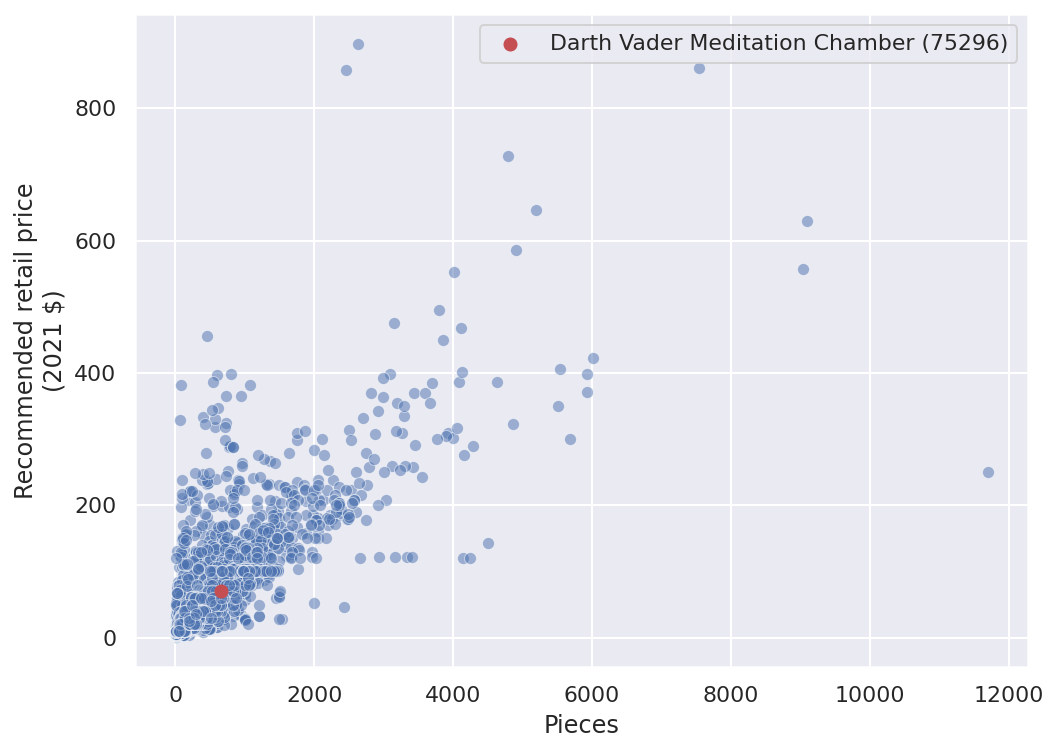

In [40]:
VADER_MEDITATION = "75296-1"

vader_label = f"{lego_df.loc[VADER_MEDITATION, 'Name']} ({VADER_MEDITATION.split('-')[0]})"

ax = sns.scatterplot(x="Pieces", y="RRP2021", data=lego_df,
                     alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Pieces"],
           lego_df.loc[VADER_MEDITATION, "RRP2021"],
           c='r', label=vader_label);

ax.set_ylabel("Recommended retail price\n(2021 $)");
ax.legend();

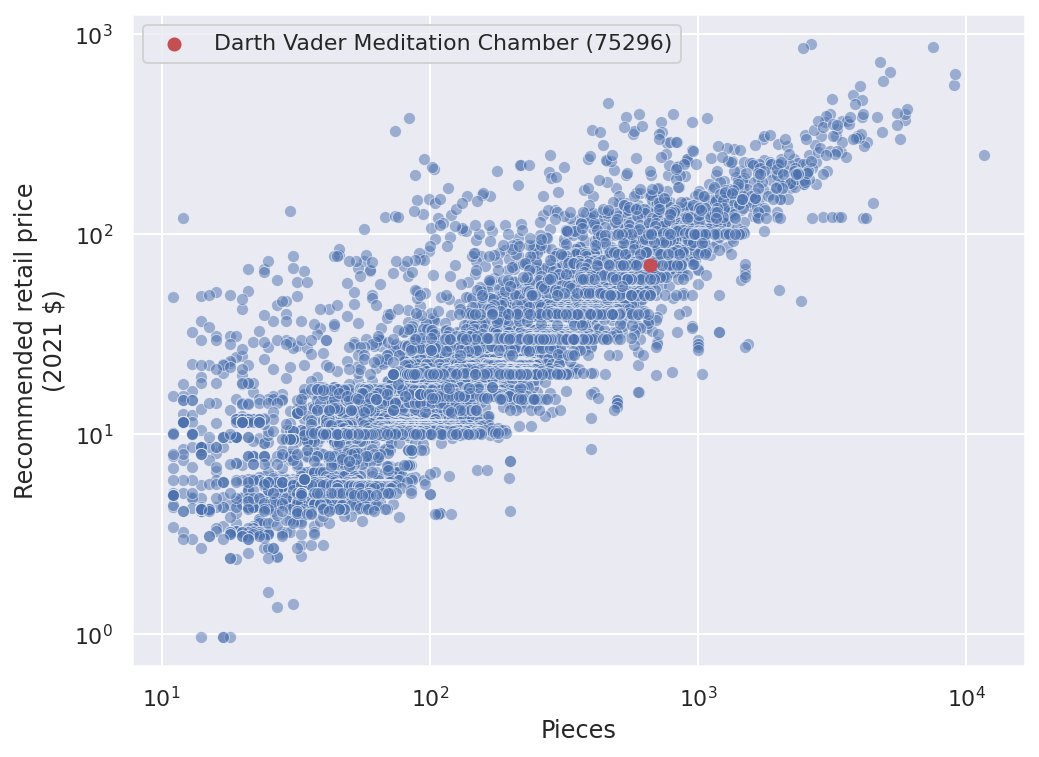

In [41]:
ax = sns.scatterplot(x="Pieces", y="RRP2021", data=lego_df,
                     alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Pieces"],
           lego_df.loc[VADER_MEDITATION, "RRP2021"],
           c='r', label=vader_label);

ax.set_xscale('log');

ax.set_yscale('log');
ax.set_ylabel("Recommended retail price\n(2021 $)");

ax.legend();

In [42]:
lego_df["LLPPP2021"] = (
    lego_df["RRP2021"]
           .pipe(np.log)
           .div(lego_df["Pieces"]
                       .pipe(np.log))
)

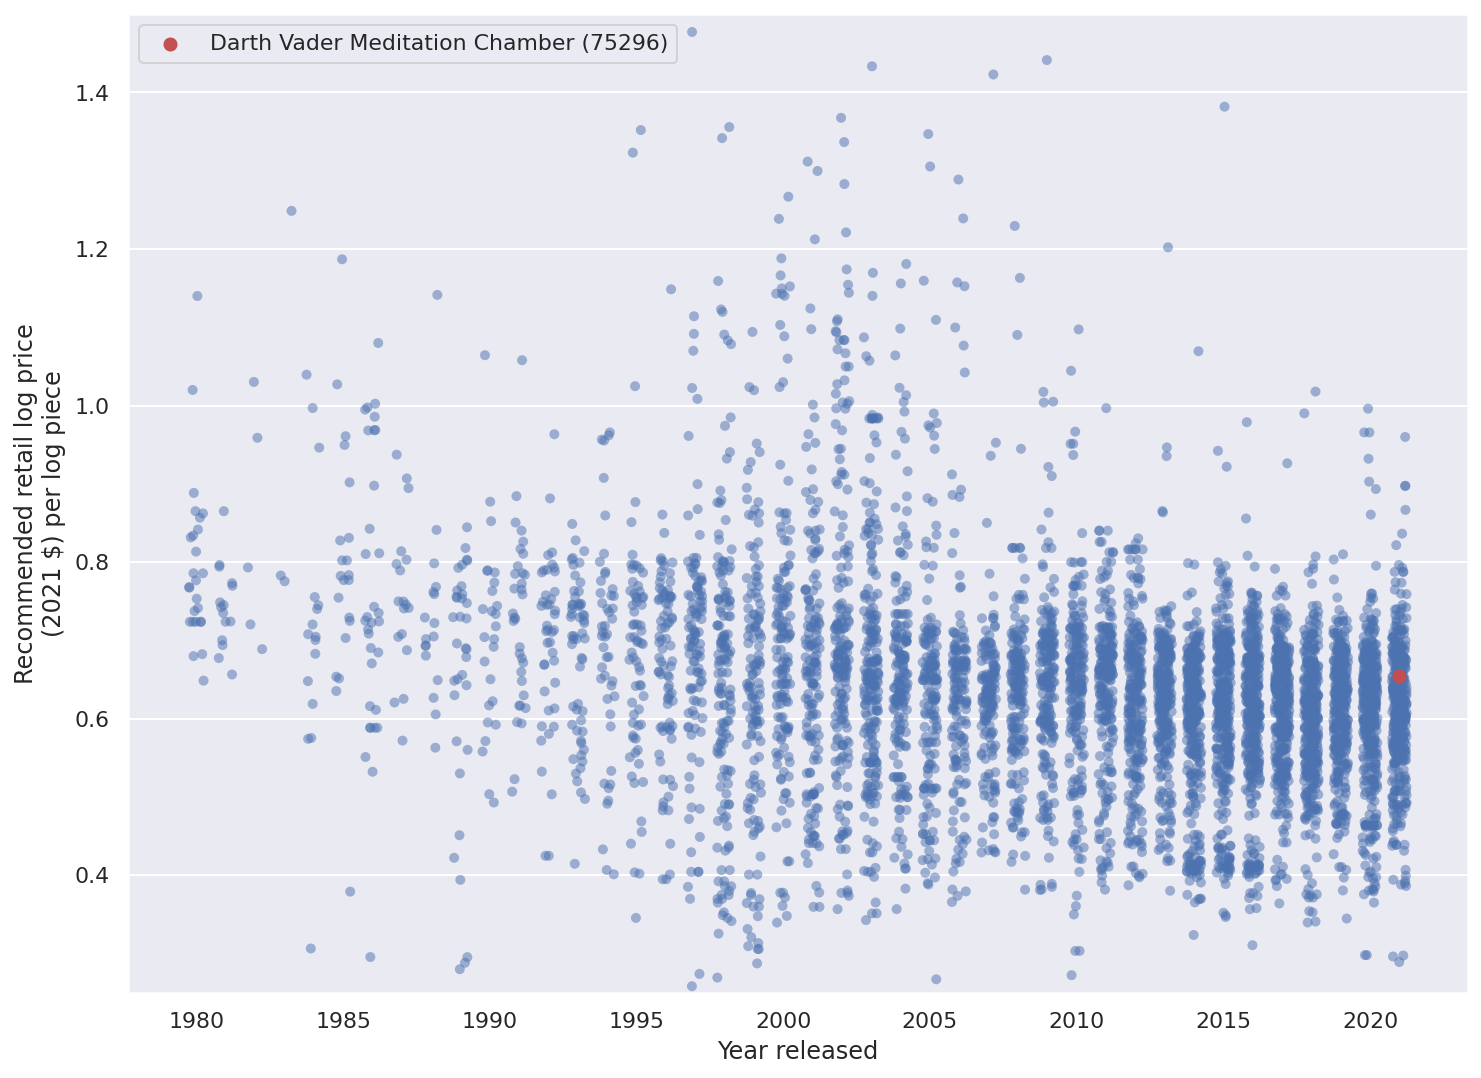

In [43]:
fig, ax = plt.subplots(figsize=1.5 * FIG_SIZE)

sns.stripplot(x="Year released", y="LLPPP2021", data=lego_df,
              jitter=0.25, color='C0', alpha=0.5, ax=ax)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Year released"] - lego_df["Year released"].min(),
           lego_df.loc[VADER_MEDITATION, "LLPPP2021"],
           c='r', zorder=10, label=vader_label);

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_ylim(0.25, 1.5);
ax.set_ylabel("Recommended retail log price\n(2021 $) per log piece");

ax.legend();

In [44]:
PLOT_THEMES = ["Star Wars", "Disney", "Marvel Super Heroes", "Creator", "City", "Friends"]

lego_df["Plot theme"] = (lego_df["Theme"]
                                .where(lego_df["Theme"].isin(PLOT_THEMES),
                                       "Other"))
theme_plot_min_year = (lego_df[lego_df["Theme"].isin(PLOT_THEMES)]
                             ["Year released"]
                             .sub(1)
                             .min())

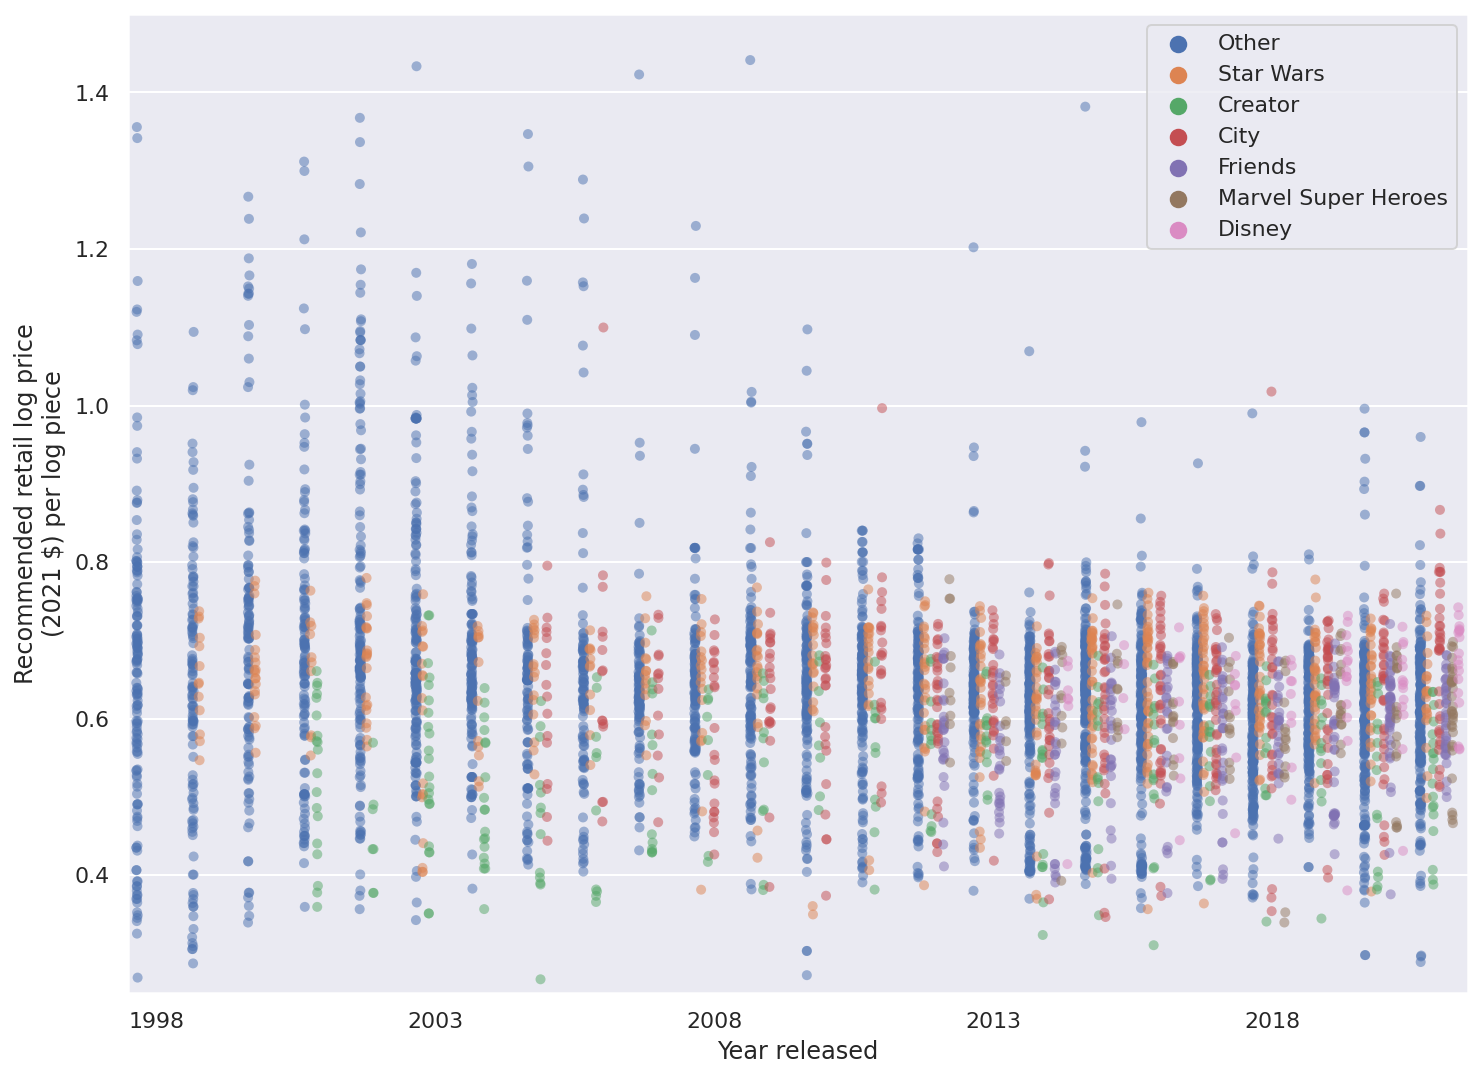

In [45]:
fig, ax = plt.subplots(figsize=1.5 * FIG_SIZE)

sns.stripplot(
    x="Year released", y="LLPPP2021", hue="Plot theme",
    data=lego_df[lego_df["Year released"] >= theme_plot_min_year],
    dodge=True, alpha=0.5, ax=ax
);

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_ylim(0.25, 1.5);
ax.set_ylabel("Recommended retail log price\n(2021 $) per log piece");

ax.legend();

In [46]:
def gaussian_random_walk(name, *, dims, innov_scale=1.):
    Δ = pm.Normal(f"Δ_{name}", 0., innov_scale,  dims=dims)

    return pm.Deterministic(name, Δ.cumsum(), dims=dims)

def noncentered_normal(name, *, dims, μ=None):
    μ = pm.Normal(f"μ_{name}", 0., 2.5)
    Δ = pm.Normal(f"Δ_{name}", 0., 1., dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5)
    
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

Feature Engineering

In [47]:
log_pieces = (lego_df["Pieces"]
                     .pipe(np.log)
                     .values)

scaler = StandardScaler().fit(log_pieces[:, np.newaxis])

def scale_log_pieces(log_pieces, scaler=scaler):
    return scaler.transform(log_pieces[:, np.newaxis])[:, 0]

std_log_pieces = scale_log_pieces(log_pieces)
log_rrp2021 = (lego_df["RRP2021"]
                      .pipe(np.log)
                      .values)
theme_id, theme_map = lego_df["Theme"].factorize(sort=True)
t, years = lego_df["Year released"].factorize(sort=True)

Model Specification

In [52]:
coords = {
    "set": lego_df.index,
    "theme": theme_map,
    "year": years
}

In [53]:
with pm.Model(coords=coords) as lego_model:
    β0_t = gaussian_random_walk("β0_t", dims="year", innov_scale=0.1)
    β0_theme = noncentered_normal("β0_theme", dims="theme")

In [54]:
with lego_model:
    β_pieces_t = gaussian_random_walk("β_pieces_t", dims="year", innov_scale=0.1)
    β_pieces_theme = noncentered_normal("β_pieces_theme", dims="theme")

In [55]:
with lego_model:
    σ = pm.HalfNormal("σ", 5.)
    μ = β0_t[t] + β0_theme[theme_id] \
        + (β_pieces_t[t] + β_pieces_theme[theme_id]) * std_log_pieces \
        - 0.5 * σ**2

In [56]:
with lego_model:
    obs = pm.Normal("obs", μ, σ, dims="set", observed=log_rrp2021)

In [ ]:
fig, ax = plt.subplots()

max_rhat = (az.rhat(mh_trace)
               .max()
               .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(left=0.8);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();